In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot CPU times for IMEX-RB on 2D nonlinear problem
We study CPU times on the 2D viscous Burgers equation

In [2]:
# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

# Paths
problem_name = "Burgers2D"
test_name = "CPUtimes"
# Find results
results_base = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
times = data['times'].item()
errors_l2 = data['errors_l2'].item()
Nh_values = data['Nh_values']
N_values = data['N_values']
inneriters = data['inneriters'].item()['IMEX-RB'] + 1

methods = ['BE', 'IMEX-RB']
methods_labels = ['BE', 'IMEX-RB']
methods_marker = ['o', 'x']


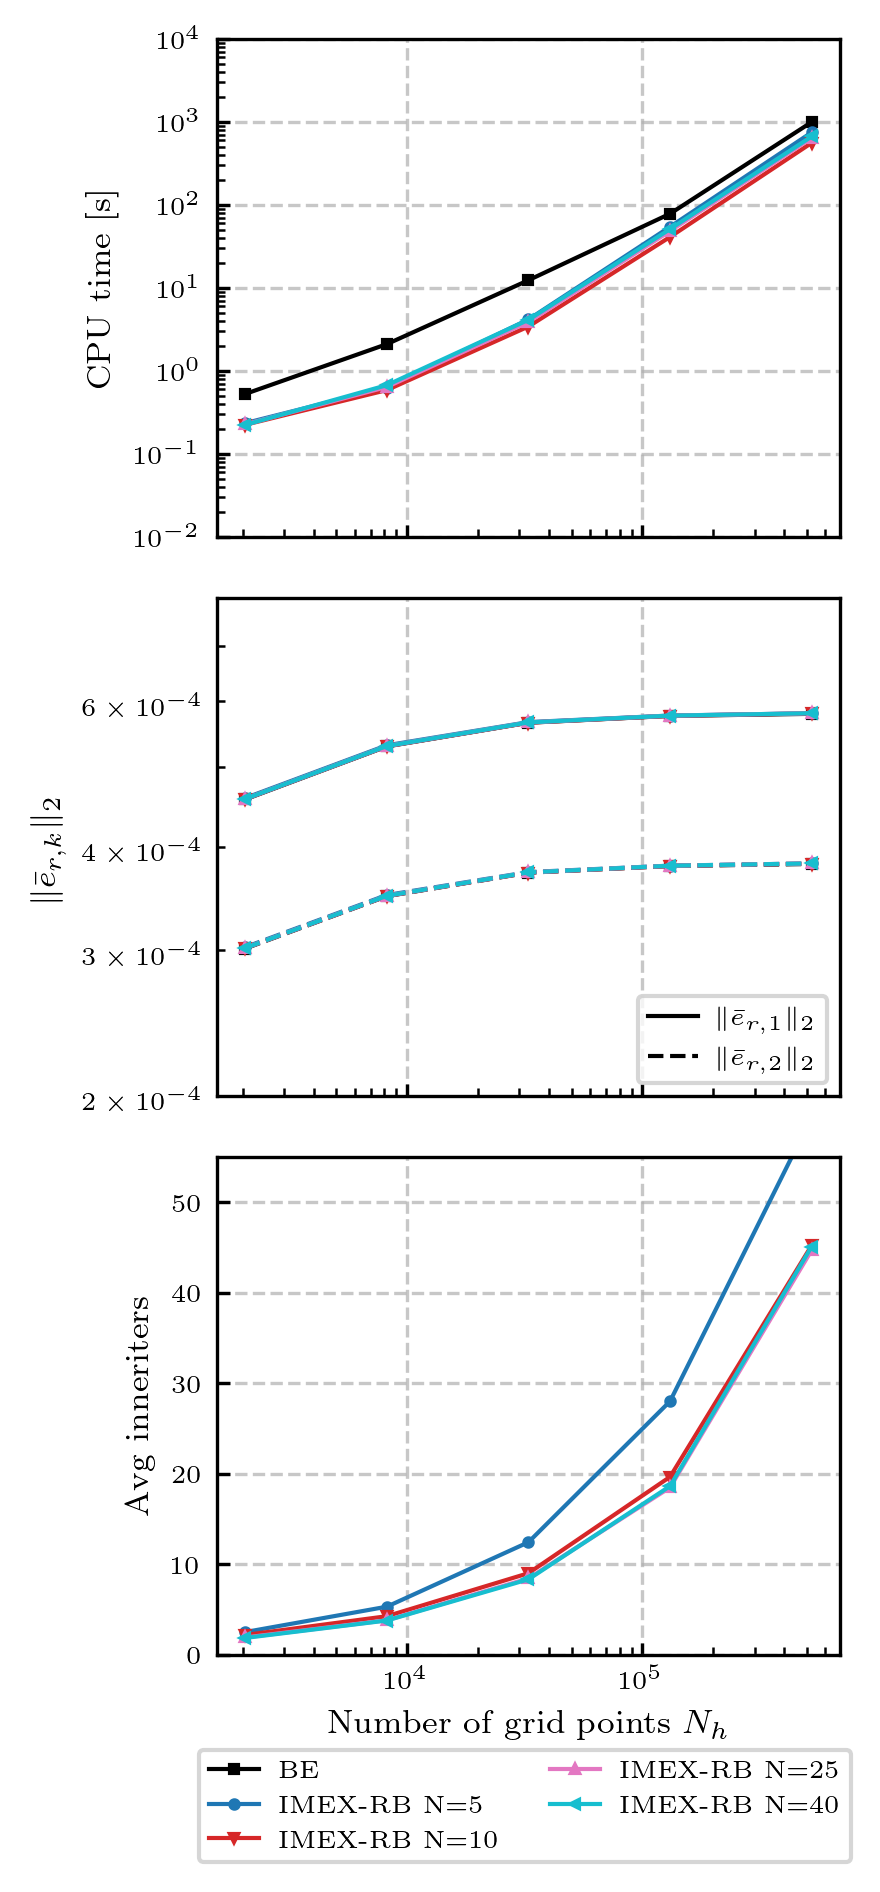

In [6]:
# Define a list of markers for the IMEX-RB curves (cyclic, if needed)
imex_markers = ['o', 'v', '^', '<', '>', 'D', 's', 'p', '*', 'h']

# (CPU times, errors, and inneriters)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3, 6), sharex=True)

# Use the tab10 palette for improved readability
colors = plt.cm.tab10(np.linspace(0, 1, len(N_values)))

# First subplot: CPU times
ax1.loglog(Nh_values, times["BE"], marker="s", color="black", label="BE")
for n_idx, N_val in enumerate(N_values):
    marker = imex_markers[n_idx % len(imex_markers)]
    ax1.loglog(Nh_values, times["IMEX-RB"][n_idx], marker=marker,
               color=colors[n_idx], label=f"IMEX-RB N={N_val}")
ax1.set_ylabel("CPU time [s]")
ax1.set_ylim((1e-2, 1e4))

# Second subplot: errors
ax2.loglog(Nh_values, errors_l2["BE"][0], marker="s", linestyle="-", 
           color="black", label="BE Err1")
ax2.loglog(Nh_values, errors_l2["BE"][1], marker="s", linestyle="--", 
           color="black", label="BE Err2")
for n_idx, N_val in enumerate(N_values):
    marker = imex_markers[n_idx % len(imex_markers)]
    ax2.loglog(Nh_values, errors_l2["IMEX-RB"][n_idx][0], marker=marker, linestyle="-", 
               color=colors[n_idx])
    ax2.loglog(Nh_values, errors_l2["IMEX-RB"][n_idx][1], marker=marker, linestyle="--", 
               color=colors[n_idx])
ax2.set_ylabel(r"$\|\bar{e}_{r,k}\|_2$")
ax2.set_ylim((2e-4, 8e-4))
# Custom legend for error components in the middle plot
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='k', linestyle='-', label=r'$\|\bar{e}_{r,1}\|_2$'),
    Line2D([0], [0], color='k', linestyle='--', label=r'$\|\bar{e}_{r,2}\|_2$')
]
ax2.legend(handles=legend_elements, loc='lower right')

# Third subplot: Average inner iterations (IMEX-RB only)
for n_idx, N_val in enumerate(N_values):
    marker = imex_markers[n_idx % len(imex_markers)]
    ax3.semilogx(Nh_values, np.mean(inneriters[n_idx], axis=1), marker=marker, linestyle="-", 
                 color=colors[n_idx], label=f"IMEX-RB, $N = {N_val}$")
ax3.set_ylabel("Avg inneriters")
ax3.set_xlabel("Number of grid points $N_h$")
ax3.set_ylim((0, 55))

plt.tight_layout()
# Remove individual axes legends and create a single global legend below ("south")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.6, -0.05))

# Save the figure
out_file = os.path.join(plots_dir, "Burgers2D_cputimes_errors_allN.pdf")
plt.savefig(out_file, bbox_inches="tight")
plt.show()